# Cauchy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
# auxiliary functions
def kl(lq,lp,randq,B=1000):
    sample=randq(B)
    return np.mean(lq(sample)-lp(sample))

In [3]:
# target definition
def lp(x): return -np.log(1+x**2)-np.log(np.pi)
def randp(size): return np.random.standard_cauchy(size)

In [4]:
# gaussian variational approximation
def lq(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*np.log(2*np.pi*sigma**2)

In [5]:
# gradients

def mu_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(sample-mu)*np.exp(-2*lsigma))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu))

def ls_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(np.exp(-2*lsigma)*(sample-mu)**2-1.))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu)**2-1.)

In [29]:
# optimization wrapper
def gaussianVI(lp,randp,divergence='rev-kl',B=1000,max_iters=1001,lr_mu=1e-2,lr_lsigma=1e-2):
    # initial values
    mus=np.zeros(max_iters+1)
    mus[0]=np.random.randn() # initialize mu at a draw from std normal (cause 0 is probably the opt, let's make it harder)
    lsigmas=np.zeros(max_iters+1)
    lsigmas[0]=np.random.randn() # ditto

    # optimize
    print('Initial μ: '+str(mus[0]))
    print('Initial σ: '+str(np.exp(lsigmas[0])))
    print()
    print('Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient')
    for t in range(max_iters):
        # calculate gradients
        grad_mu=mu_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
        grad_lsigma=ls_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
    
        # take step
        mus[t+1]=mus[t]-grad_mu*lr_mu/np.sqrt(t+1)
        lsigmas[t+1]=lsigmas[t]-grad_lsigma*lr_lsigma/np.sqrt(t+1)
    
        # do printout
        if t%(max_iters//10)==0: print('  '+str(t)+'   | '+str(mus[t+1])+'   | '+str(np.exp(lsigmas[t+1]))+'   | '+str(grad_mu)+'  | '+str(grad_lsigma))
    # end for
    
    print()
    print('Final μ: '+str(mus[-1]))
    print('Final σ: '+str(np.exp(lsigmas[-1])))
    return mus,lsigmas

In [38]:
# rev kl opt

# settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=1e1
lr_lsigma=1e1
divergence='rev-kl'

rev_mus,rev_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | 6.67839608484994   | 6667.959742638883   | -0.8089341133284977  | -0.9085391091811823
  1000   | 0.00094020128376102   | 1.6486862454013598   | -0.001261412073914488  | 0.004141443392315613
  2000   | 0.003910347676078475   | 1.644938343274284   | 0.0009418228271306582  | 0.024794787290442905
  3000   | 0.0008474207767216312   | 1.641579348947717   | 0.0009158101809678974  | 0.0048999277756437785
  4000   | -0.0014572119815890175   | 1.642665632871073   | 0.002716916405600724  | 0.01350844782028627
  5000   | -0.0003502833744694376   | 1.6375330279184088   | 0.0031582762359665816  | 0.025029247057568732
  6000   | 0.0004166671782055221   | 1.645768011043134   | -0.0009134212404090628  | 0.004625928761469304
  7000   | -0.004351160995914036   | 1.6372207915051906   | 0.0022037356535213556  | -0.030040620881970004
  8000   | 0.000

In [39]:
rev_mu=rev_mus[-1]
rev_lsigma=rev_lsigmas[-1]

rev_lq = lambda x : lq(x,rev_mu,rev_lsigma)
rev_randq = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

In [52]:
# fwd kl opt
# settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=1e-1
lr_lsigma=1e-11
divergence='fwd-kl'

fwd_mus,fwd_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.9644684106014652   | 0.7555405779209228   | -4.4647663783357245  | -9666.545373536233
  1000   | 0.03473601161315043   | 5.2815241030542435   | -0.043137704947975274  | -374.13324831017894
  2000   | -0.10813123856687222   | 5.282806955572553   | 1.3070702815178292  | -164.5277378465556
  3000   | -0.027903724958935675   | 5.285018026816807   | -0.04385776961680918  | -84.70163743982204
  4000   | 0.030034980312466982   | 5.285044511129903   | 0.001867898279970951  | -3644.487352863359
  5000   | -0.0032152292971904897   | 5.285491468931587   | -0.020242288078850357  | -80.15206488856133
  6000   | -0.012702526985727377   | 5.285590572362497   | 0.04490184561764447  | -182.9870421514953
  7000   | -0.007539453420878413   | 5.286291350975518   | 0.019501692047503117  | -76.03771034133237
  8000   | 0.00933320130337748   | 5.28

In [53]:
fwd_mu=fwd_mus[-1]
fwd_lsigma=fwd_lsigmas[-1]

fwd_lq = lambda x : lq(x,fwd_mu,fwd_lsigma)
fwd_randq = lambda B : fwd_mu+np.exp(fwd_lsigma)*np.random.randn(B)

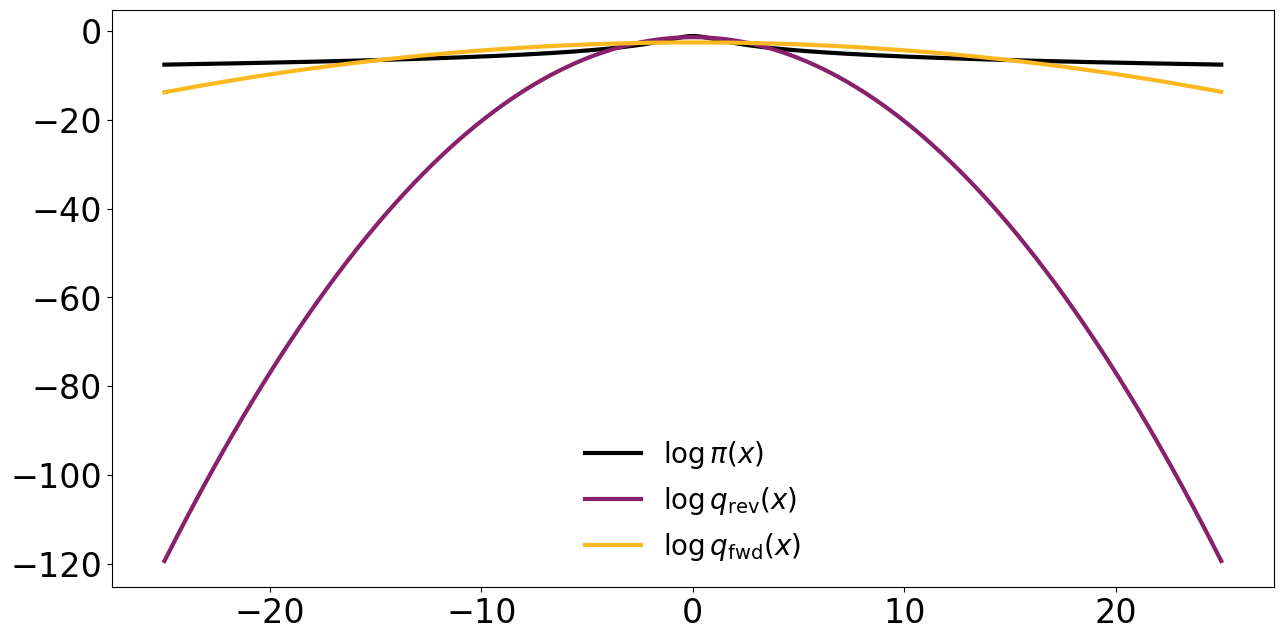

In [56]:
lsx=np.linspace(-25,25,1000)
plt.plot(lsx,lp(lsx),c="black", label=r'$\log\pi(x)$',lw=3)
plt.plot(lsx,rev_lq(lsx),c='#87216BFF', label=r'$\log q_{\mathrm{rev}}(x)$',lw=3)
plt.plot(lsx,fwd_lq(lsx),c='#FBB91FFF', label=r'$\log q_{\mathrm{fwd}}(x)$',lw=3)
plt.legend(fontsize='small',frameon=False)

In [57]:
rev_kl=kl(rev_lq,lp,rev_randq,B=10000)
fwd_kl=kl(lp,fwd_lq,randp,B=10000)
print('Reverse KL: '+str(rev_kl))
print('Forward KL: '+str(fwd_kl))

Reverse KL: 0.18654597508490378
Forward KL: 370.4228356929126


## Credible interval comparison

In [194]:
alphas=np.flip(np.linspace(0.01,0.2,101)[1:])
true_lims=stats.cauchy.ppf(1-alphas/2)
rev_lims=stats.norm.ppf(1-alphas/2,loc=rev_mu,scale=np.exp(rev_lsigma))
fwd_lims=stats.norm.ppf(1-alphas/2,loc=fwd_mu,scale=np.exp(fwd_lsigma))

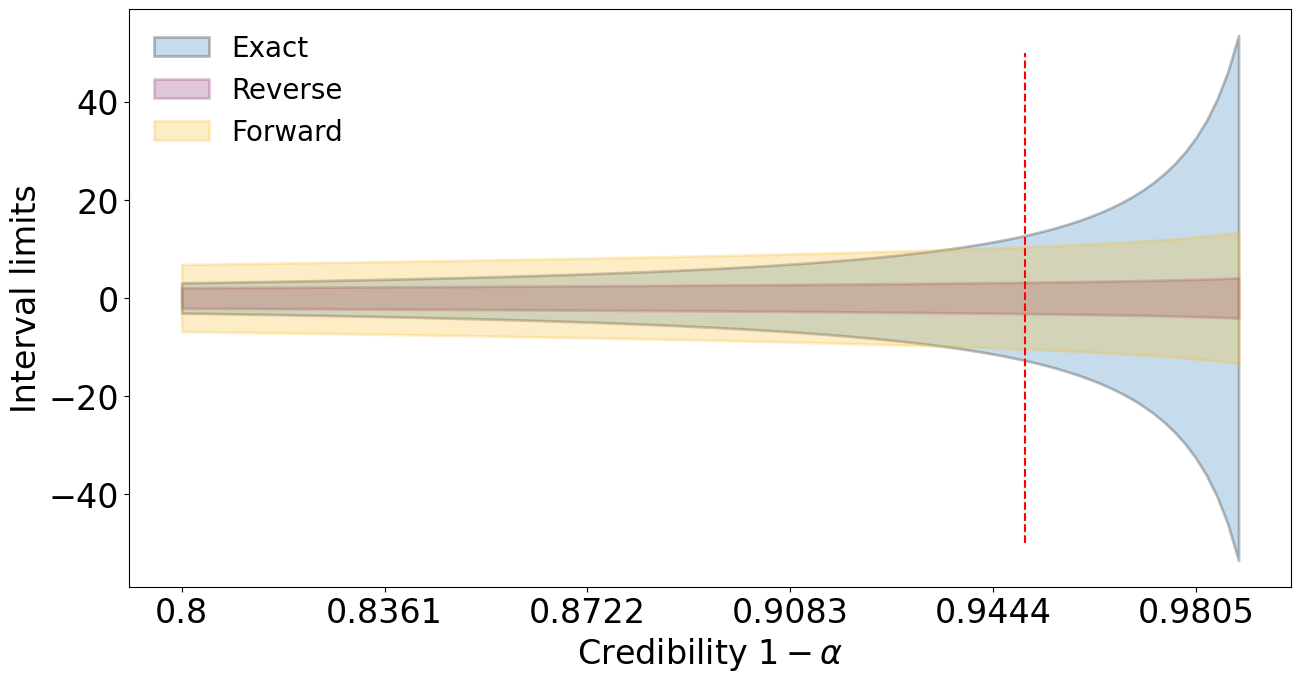

In [215]:
lsa=np.arange(0,alphas.shape[0])
#plt.errorbar(x=lsa,y=np.zeros(alphas.shape[0]),yerr=true_lims[1,:])
plt.fill_between(x=lsa,y1=true_lims,y2=-true_lims,label='Exact',alpha=0.25,ec='black',lw=2)
plt.fill_between(x=lsa,y1=rev_lims,y2=-rev_lims,label='Reverse',alpha=0.25,ec='black',lw=2,color='#87216BFF')
plt.fill_between(x=lsa,y1=fwd_lims,y2=-fwd_lims,label='Forward',alpha=0.25,ec='black',lw=2,color='#FBB91FFF')
plt.vlines(np.argmax(alphas==0.0499),-50,50,ls='dashed',color='red')

plt.ylabel('Interval limits')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');

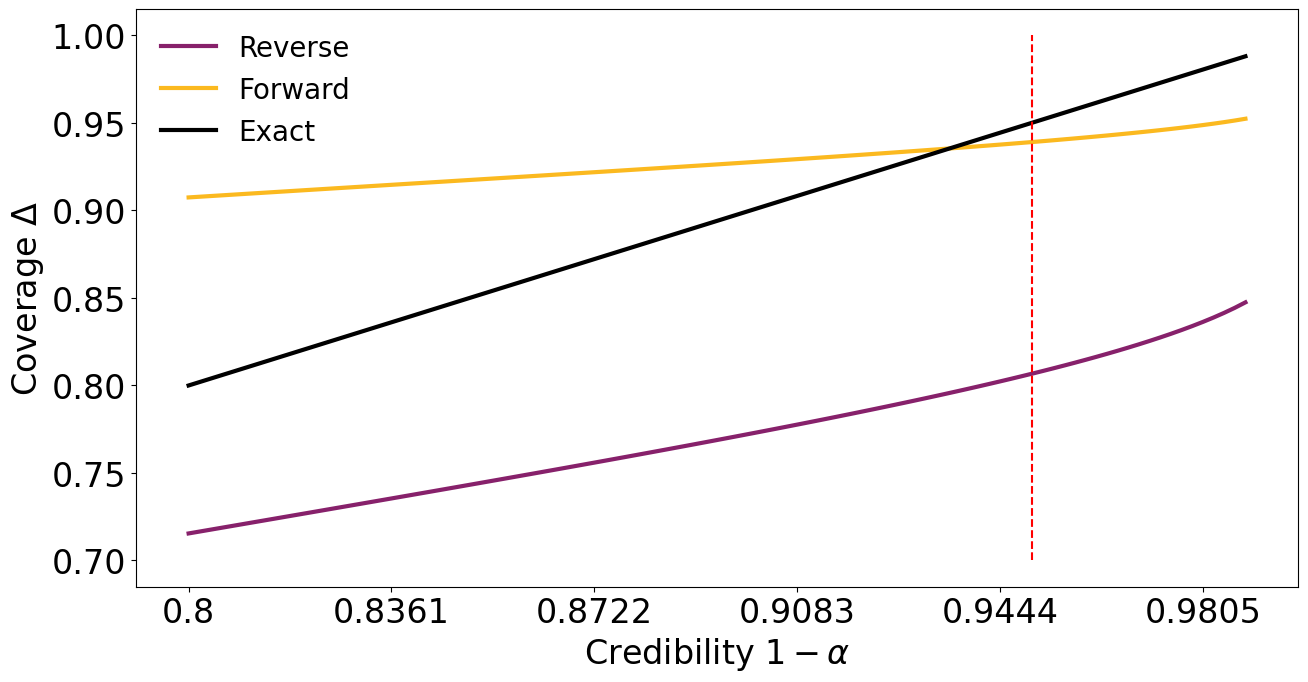

In [213]:
plt.plot(lsa,1-2*stats.cauchy.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF')
plt.plot(lsa,1-2*stats.cauchy.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF')
plt.plot(lsa,1-alphas[lsa],label='Exact',lw=3,color='black')
plt.vlines(np.argmax(alphas==0.0499),0.7,1,ls='dashed',color='red')

plt.ylabel(r'Coverage $\Delta$')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');

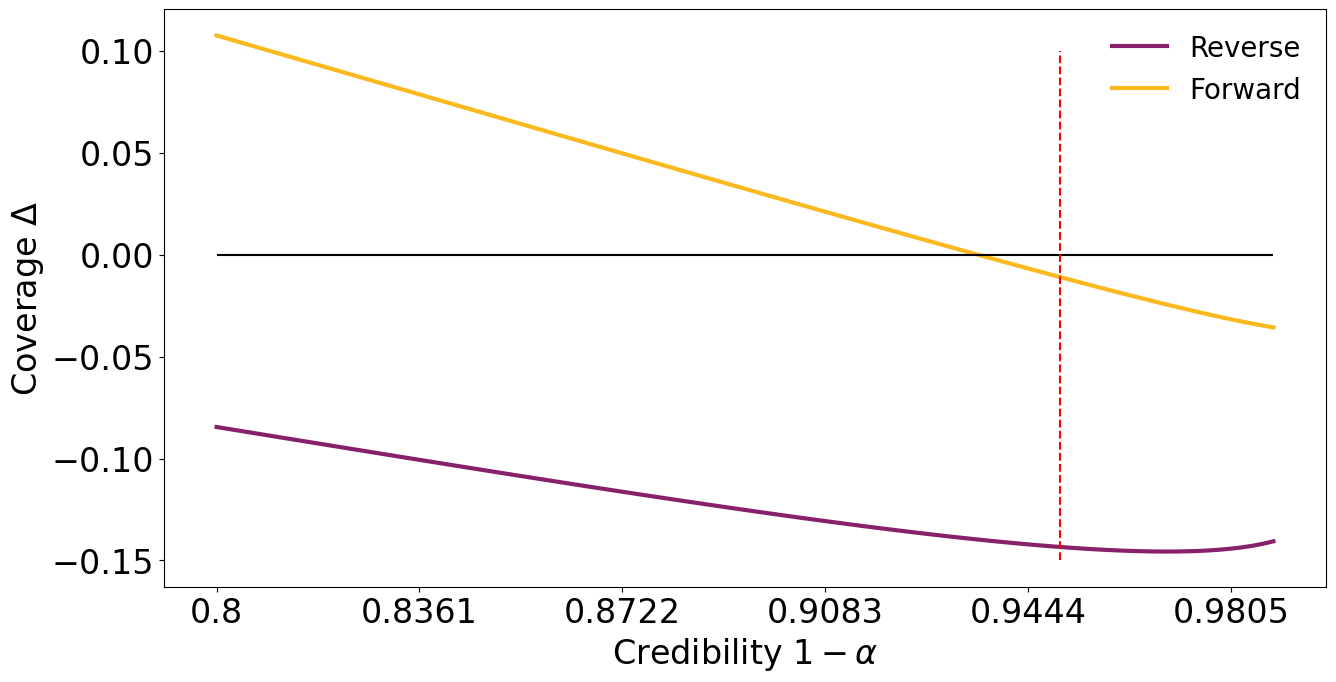

In [216]:
plt.plot(lsa,alphas-2*stats.cauchy.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF')
plt.plot(lsa,alphas-2*stats.cauchy.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF')
plt.hlines(0,lsa[0],lsa[-1],color='black')
plt.vlines(np.argmax(alphas==0.0499),-0.15,0.1,ls='dashed',color='red')

plt.ylabel(r'Coverage $\Delta$')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper right');